各種必要なものを取りいれる

In [1]:
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import numpy as np
from qiskit import transpile
from qiskit.quantum_info import Kraus, SuperOp, Operator
from qiskit.extensions import RYGate
from qiskit.providers.aer import AerSimulator
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
import scipy.optimize as opt
import statistics
import math
%matplotlib inline
import matplotlib.pyplot as plt

パラメータの設定

In [4]:
k=10
p=0.9
pi=np.pi
theta=pi/8
Ng=2*k+1
theta_0=pi/10
theta_m=2*Ng*theta_0+pi/2

ノイズモデルの導入

In [5]:
# Create an empty noise model
noise_depolarizing = NoiseModel()
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(1-p, 1)
noise_depolarizing.add_all_qubit_quantum_error(error, ['id','u1','u2','u3'])
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_depolarizing)
# Print noise model info
print(noise_depolarizing)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1', 'id']
  All-qubits errors: ['id', 'u1', 'u2', 'u3']


noise検証

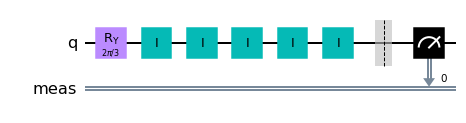

In [6]:
circ=QuantumCircuit(1)
circ.ry(2*pi/3,0)
for i in range(5):
    circ.id(0)
circ.measure_all()
circ.draw('mpl')

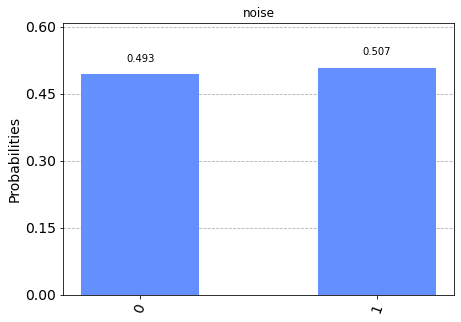

In [7]:
# Create an empty noise model
noise_depolarizing = NoiseModel()
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(1, 1)
noise_depolarizing.add_all_qubit_quantum_error(error,['id','u3'])
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_depolarizing)
circ_noise=transpile(circ,sim_noise)
result=sim_noise.run(circ_noise).result()
counts=result.get_counts(circ_noise)
plot_histogram(counts,title='noise')

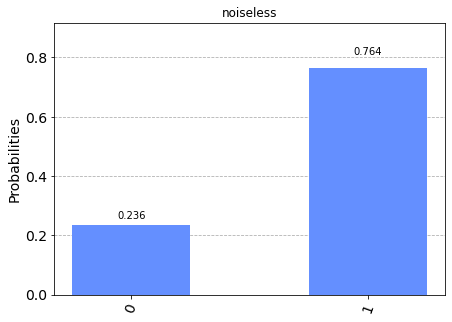

In [8]:
simulator=Aer.get_backend('aer_simulator')
circ=transpile(circ,simulator)
result=simulator.run(circ).result()
counts=result.get_counts(circ)
plot_histogram(counts,title='noiseless')

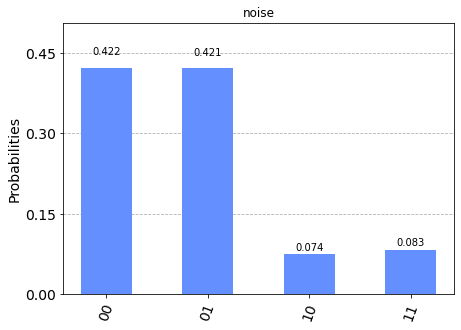

In [16]:
# Create an empty noise model
noise_depolarizing = NoiseModel()
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(1, 1)
noise_depolarizing.add_all_qubit_quantum_error(error, ['id','u1','u2','u3'])
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_depolarizing)
circ_noise=transpile(circ,sim_noise)
result=sim_noise.run(circ).result()
counts=result.get_counts(circ)
plot_histogram(counts,title='noise')

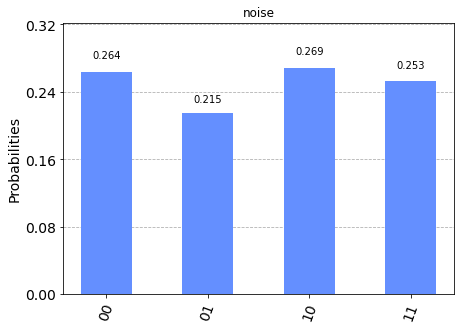

In [17]:
circ_noise=transpile(circ,sim_noise)
result=sim_noise.run(circ_noise).result()
counts=result.get_counts(circ_noise)
plot_histogram(counts,title='noise')

In [18]:
# Create an empty noise model
noise_depolarizing = NoiseModel()
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(1, 1)
print(error)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.25, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.25, QasmQobjInstructions = [[{'name': 'y', 'qubits': [0]}]
  P(2) = 0.25, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.25, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


idに対してはnoiseが働かない，ry位相0にも働かない(回路内に該当ゲートがある時に，回路全体に対して設定したdepolarizingがかかるようなイメージ→idのnoiseには機能しないという矛盾が生じた)


ryを複数回かけてもnoiseが強くなるような振る舞いは見せなかった

位相増幅に伴ってエラーをかけるのが最適か

errorの中身は，反転などを足して和を取ると平均1:1になる性質を利用していると思われる

量子回路の作成

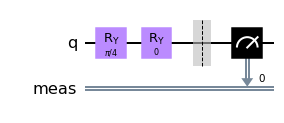

In [19]:
k=0
circ=QuantumCircuit(1)
circ.ry(2*theta,0)
circ.ry(4*k*theta,0)
circ.measure_all()
circ.draw('mpl')

2qubit量子回路

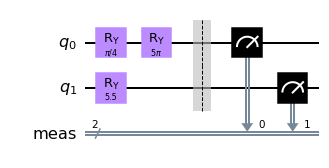

In [20]:
k=10
p=0.9
pi=np.pi
theta=pi/8
Ng=2*k+1
theta_0=pi/10
theta_m=2*Ng*theta_0+pi/2
circ=QuantumCircuit(2)
circ.ry(2*theta,0)
circ.ry(4*k*theta,0)
circ.ry(5.5,1)
circ.measure_all()
circ.draw('mpl')

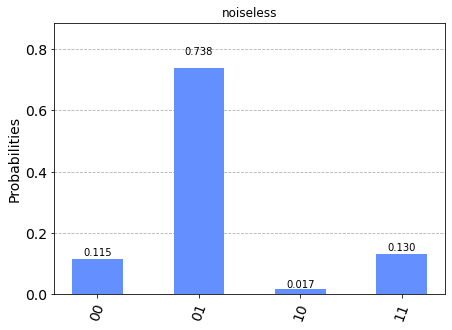

In [21]:
simulator=Aer.get_backend('aer_simulator')
circ=transpile(circ,simulator)
result=simulator.run(circ).result()
counts=result.get_counts(circ)
plot_histogram(counts,title='noiseless')

ノイズを含んだ実行

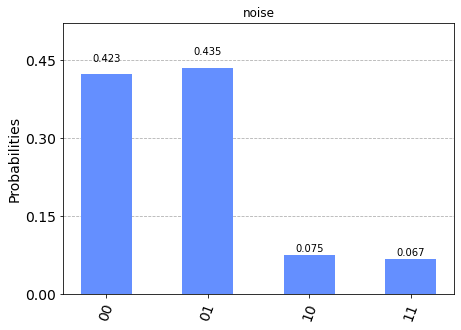

In [22]:
circ_noise=transpile(circ,sim_noise)
result=sim_noise.run(circ).result()
counts=result.get_counts(circ)
plot_histogram(counts,title='noise')

固有ベクトル測定を行う回路の作成

In [23]:
circ_e=QuantumCircuit(1)
circ_e.ry(2*theta,0)
circ_e.ry(4*m*theta,0)
circ_e.ry(-theta_m,0)
circ_e.measure_all()
circ_e.draw('mpl')

NameError: name 'm' is not defined

固有ベクトル測定

In [78]:
a=0.75
m=1
p=0.99
pi=np.pi
theta=np.arcsin(np.sqrt(a))
Ng=2*m+1
opt_results=[]
n0=[]
n1=[]
theta_0=[theta]
for i in range(100):
    theta_m=2*Ng*theta_0[i]+pi/2
    circ_e=QuantumCircuit(1)
    circ_e.ry(2*theta,0)
    circ_e.ry(4*m*theta,0)
    circ_e.ry(-theta_m,0)
    circ_e.measure_all()
    # Create an empty noise model
    noise_depolarizing = NoiseModel()
    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error = depolarizing_error(1-p**(m+1), 1)
    noise_depolarizing.add_all_qubit_quantum_error(error, ['u1','u2','u3'])
    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=noise_depolarizing)
    # Transpile circuit for noisy basis gates
    circ_e_tnoise = transpile(circ_e, sim_noise)
    # Run and get counts
    result_noise = sim_noise.run(circ_e_tnoise,shots=10000).result()
    counts_noise = result_noise.get_counts(0)
    n0.append(counts_noise['0'])
    n1.append(counts_noise['1'])
    def func(x):
        ans=0
        for j in range(i+1):
            angle=x[0]-theta_0[j]
            ans+=np.log((1+(p**(m+1))*np.sin(2*Ng*angle))/2)*n0[j]
            ans+=np.log((1-(p**(m+1))*np.sin(2*Ng*angle))/2)*n1[j]
        return -ans
    x=opt.brute(func,[(0,pi/2)])
    opt_results.append(np.sin(x[0])**2)
    theta_0.append(x[0])
print(opt_results)
print(statistics.mean(opt_results))
print(theta_0)
print(n0)

[2.4999997916666736e-07, 0.9999998529314412, 0.9999998529314412, 0.9999998937429647, 0.9999999941172573, 0.9999999844658828, 0.999999867270625, 0.9999999941172573, 0.9999999734357405, 0.9999999058761206, 0.9999998999014607, 0.9999998529314412, 0.9999998220470455, 0.9999997969534747, 3.814697217118617e-08, 0.9999995623791619, 0.9999997219485179, 0.9999997655865116, 0.9999997466514369, 0.9999996690957628, 0.9999997319675622, 0.9999998220470455, 0.9999997747782956, 0.9999996800339851, 0.9999997117456382, 0.9999996960966266, 0.9999997269810197, 0.9999997065752599, 0.9999996854341578, 0.9999996907883716, 0.9999995873808109, 0.9999996351780827, 1.8463134754262084e-09, 1.8463134754262084e-09, 9.765624996821087e-10, 9.765624996821087e-10, 3.9062499949137365e-09, 2.990722653268526e-09, 3.9062499949137365e-09, 1.0314941370783997e-08, 8.789062474250794e-09, 3.9062499949137365e-09, 6.103515612582366e-09, 4.409790032580418e-09, 1.1962890577296418e-08, 1.3732910093385726e-08, 2.4414062301317852e-08,

In [64]:
print(np.arcsin(np.sqrt(a))*Ng)

1.3909428270024182


adaptive固有ベクトル測定

In [69]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/4]
Ng=[]
m=[]
for k in range(5):
    Ng.append(2*k+1)
    m.append([k+1])
    n0.append([])
    n1.append([])
    for i in range(100):
        theta_m=2*Ng[k]*theta_0[i+k*100]+pi/2
        circ_e=QuantumCircuit(1)
        circ_e.ry(2*theta,0)
        circ_e.ry(4*k*theta,0)
        circ_e.ry(-theta_m,0)
        circ_e.measure_all()
        # Run and get counts
        result_noise = sim_noise.run(circ_e_tnoise,shots=10000).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['0'])
        n1[k].append(counts_noise['1'])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]-theta_0[j+l*100]
                    ans+=np.log((1+(p**m)*np.sin(2*Ng[l]*angle))/2)*n0[l][j]
                    ans+=np.log((1-(p**m)*np.sin(2*Ng[l]*angle))/2)*n1[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)

TypeError: unsupported operand type(s) for ** or pow(): 'float' and 'list'

noiseが更新されておらず下の回路が正しい

In [70]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/100]
Ng=[]
m=[]
it=100
for k in range(100):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    for i in range(it):
        theta_m=2*Ng[k]*theta_0[i+k*it]+pi/2
        circ_e=QuantumCircuit(1)
        circ_e.ry(2*theta,0)
        circ_e.ry(4*k*theta,0)
        circ_e.ry(-theta_m,0)
        circ_e.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), 1)
        noise_depolarizing.add_all_qubit_quantum_error(error, ['u1','u2','u3'])
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_e_tnoise = transpile(circ_e, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e_tnoise,shots=2000).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['0'])
        n1[k].append(counts_noise['1'])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]-theta_0[j+l*it]
                    ans+=np.log((1+(p**m[l])*np.sin(2*Ng[l]*angle))/2)*n0[l][j]
                    ans+=np.log((1-(p**m[l])*np.sin(2*Ng[l]*angle))/2)*n1[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)

KeyboardInterrupt: 

In [521]:
pvariance = statistics.pvariance(opt_results)
print(pvariance)

0.0008388758202971412


In [402]:
mean=statistics.mean(opt_results)
print(mean)
print(n0)

0.19703581568466852
[[5417, 4918, 4954, 5097, 4951, 4945, 4982, 5028, 5046, 4928, 4996, 4974, 5040, 5045, 4970, 4996, 4985, 4990, 5050, 5002, 4963, 4968, 4951, 5030, 4906, 4987, 4979, 4980, 5016, 4962, 4974, 4952, 5076, 5054, 5012, 5076, 5046, 5010, 5011, 5063, 5030, 5000, 5046, 4988, 5039, 5037, 5040, 5034, 5006, 5076, 5074, 5145, 5027, 5027, 4992, 5013, 4966, 4929, 5061, 4964, 5058, 4986, 5078, 5002, 5016, 5033, 4958, 4977, 5004, 4998, 5045, 5060, 5013, 4966, 4984, 5055, 5029, 4989, 4983, 4998, 4980, 5092, 4938, 5017, 4968, 5102, 5045, 5023, 4992, 5010, 4978, 5000, 4943, 4954, 5006, 4982, 5123, 5049, 5032, 4903], [5037, 4906, 5007, 5016, 4985, 5051, 4997, 4971, 5064, 4963, 4933, 4956, 5110, 5026, 5014, 5043, 4993, 5037, 5046, 4956, 5012, 4985, 5045, 4994, 4882, 4938, 4967, 5013, 5031, 4970, 4944, 5008, 4990, 4951, 5037, 5007, 4942, 4949, 4906, 4998, 4972, 5008, 5062, 5025, 5064, 4982, 4944, 5060, 4995, 4945, 5062, 5019, 5023, 5061, 4978, 5071, 5078, 5021, 5062, 4977, 4991, 4950, 5004

In [376]:
print(m)

[1, 2, 3, 4, 5]


In [502]:
print(np.sin(pi/20))

0.15643446504023087


In [504]:
print(np.sin(3*pi/20))

0.45399049973954675


計算基底測定

In [506]:
a=np.sin(pi/20)
p=1
k=1
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
Ng=2*k+1
for i in range(100):
    circ_c=QuantumCircuit(1)
    circ_c.ry(2*Ng*theta,0)
    circ_c.measure_all()
    # Create an empty noise model
    noise_depolarizing = NoiseModel()
    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error = depolarizing_error(1-p**(k+1), 1)
    noise_depolarizing.add_all_qubit_quantum_error(error, ['u1','u2','u3'])
    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=noise_depolarizing)
    # Transpile circuit for noisy basis gates
    circ_c_tnoise = transpile(circ_c, sim_noise)
    # Run and get counts
    result_noise = sim_noise.run(circ_c_tnoise,shots=10000).result()
    counts_noise = result_noise.get_counts(0)
    n0.append(counts_noise['0'])
    n1.append(counts_noise['1'])
def func(x):
    ans=0
    for j in range(100):
        angle=x[0]
        ans+=np.log(np.cos(Ng*angle))*n0[j]*2
        ans+=np.log(np.sin(Ng*angle))*n1[j]*2
    return -ans
x=opt.brute(func,[(0,pi/2)])
opt_results.append(np.sin(x[0])**2)
print(opt_results)

[0.2991522876735152]


C:\Users\k0e8i\Anaconda3\envs\qc\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
C:\Users\k0e8i\Anaconda3\envs\qc\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
C:\Users\k0e8i\Anaconda3\envs\qc\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


In [524]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
Ng=[]
m=[]
for k in range(100):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    for i in range(1):
        circ_c=QuantumCircuit(1)
        circ_c.ry(2*theta,0)
        circ_c.ry(4*k*theta,0)
        circ_c.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), 1)
        noise_depolarizing.add_all_qubit_quantum_error(error, ['u1','u2','u3'])
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_c_tnoise = transpile(circ_c, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_c_tnoise,shots=100).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['0'])
        n1[k].append(counts_noise['1'])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]
                    ans+=np.log((1+(p**m[l])*np.cos(2*Ng[l]*angle))/2)*n0[l][j]
                    ans+=np.log((1-(p**m[l])*np.cos(2*Ng[l]*angle))/2)*n1[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
print(opt_results)

[0.24444597607331092, 0.2094878756060111, 0.2064994116766037, 0.20298103297373532, 0.19956267335866143, 0.19793886689181295, 0.2008808280428483, 0.1973987081571365, 0.19732158804541688, 0.1977073021874967, 0.19801607781237732, 0.19817053366480175, 0.19759155813554447, 0.19724447929783706, 0.19763013664817708, 0.1977073021874967, 0.19936910168874916, 0.19971758145676072, 0.19998877912843271, 0.19921429514333291, 0.19925299254569093, 0.19902085048784748, 0.19878881013306635, 0.1988274764594893, 0.19875014663390658, 0.19875014663390658, 0.19836366722160853, 0.19828640530258668, 0.19832503484628947, 0.19832503484628947, 0.19832503484628947, 0.19824777859086276, 0.19820915471148026, 0.1984023024281813, 0.1985955209171567, 0.1985955209171567, 0.19871148596237287, 0.19878881013306635, 0.19875014663390658, 0.19878881013306635, 0.19878881013306635, 0.19913690880878826, 0.1991756005642443, 0.19913690880878826, 0.19913690880878826, 0.1991756005642443, 0.19929169277095518, 0.19933039581876233, 0.1

In [523]:
pvariance_c=statistics.pvariance(opt_results)
print(pvariance_c)

1.8777502487532525e-08


In [459]:
print(n0)

[[7709], [1239], [4671], [8175], [3582], [3114], [7054], [5416], [3096], [5551], [6265], [3827], [4487], [6157], [4848], [4133], [5652], [5336], [4296], [5013], [5618], [4785], [4703], [5358], [4992], [4662], [5201], [5183], [4822], [4989], [5207], [4956], [4853], [5071], [5042], [4875], [5029], [5068], [4934], [5017], [4997], [4947], [5077], [4971], [5015], [5020], [5033], [4951], [4921], [4971], [5041], [5062], [4983], [5012], [5008], [4913], [5010], [5020], [5034], [4909], [4987], [5018], [4944], [5058], [4967], [4989], [4944], [5101], [4983], [5019], [5007], [4912], [4941], [4986], [4873], [4915], [5031], [5008], [5006], [4981], [4974], [5038], [4954], [4952], [4994], [4928], [5045], [5030], [4969], [4978], [4999], [5056], [5027], [4973], [5049], [5025], [4977], [5018], [5018], [5027], [4906], [5026], [4964], [4984], [5033], [5000], [4916], [5028], [5051], [4942], [5036], [5024], [4973], [5009], [5007], [5004], [5027], [4963], [5002], [4989], [5094], [4934], [4981], [4978], [4973],

In [416]:
print(n0)

[8018, 7962, 7964, 7975, 7939, 8033, 7984, 8030, 7954, 8002, 8013, 8003, 7959, 7971, 8005, 8081, 8001, 7988, 8009, 8038, 7963, 8001, 8000, 8040, 8023, 8015, 7987, 8008, 8050, 7978, 7972, 8010, 7986, 8001, 8006, 8048, 7963, 7991, 8042, 8058, 8051, 8051, 7992, 7973, 8005, 7982, 8004, 7963, 7955, 8051, 8044, 7966, 7992, 7987, 8054, 7941, 8056, 8035, 7985, 8043, 7967, 7942, 7923, 8017, 7968, 7992, 7952, 7973, 7987, 7916, 7980, 8046, 8001, 7976, 8063, 7981, 7989, 7946, 8005, 7969, 7994, 8069, 8031, 7938, 7986, 7937, 8025, 8065, 8001, 7996, 8021, 7980, 8054, 8018, 8039, 8018, 8051, 8068, 7986, 8018]


In [349]:
print(error)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.162830389975, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.162830389975, QasmQobjInstructions = [[{'name': 'y', 'qubits': [0]}]
  P(2) = 0.162830389975, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.511508830075, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [358]:
print(1-0.9**10)

0.6513215599


adaptiveイテレーション操作確認

In [39]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/4]
Ng=[]
for k in range(10):
    n0.append([])
    n1.append([])
    for i in range(10):
        circ=QuantumCircuit(1)
        circ.ry(2*theta,0)
        circ.measure_all()
        # Transpile circuit for noisy basis gates
        circ_tnoise = transpile(circ, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_tnoise,shots=10000).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['0'])
        n1[k].append(counts_noise['1'])
print(n0)

[[5969, 5860, 5987, 6013, 5870, 5876, 5940, 5948, 5946, 5959], [5947, 5917, 5955, 6010, 5938, 5947, 5975, 5964, 5883, 5929], [5966, 5908, 5940, 6021, 5945, 5952, 5911, 5987, 5869, 5985], [5948, 5989, 6022, 5931, 5971, 5922, 5981, 6007, 5832, 5970], [6001, 5893, 6017, 5885, 5946, 5861, 5924, 5929, 5923, 5913], [5907, 5977, 6023, 5955, 5947, 5922, 5997, 5951, 5924, 5967], [6021, 6000, 5980, 5995, 5885, 5923, 5841, 5875, 5934, 5939], [5906, 5928, 5949, 5856, 5886, 5963, 5864, 5908, 5875, 5883], [5900, 5930, 5922, 5937, 5972, 5894, 6015, 5914, 5970, 6021], [6005, 5999, 5909, 6003, 5904, 5979, 5976, 5959, 5879, 5970]]


adaptiveイテレーションnoise作成込み

In [43]:
a=0.2
p=0.8
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/4]
Ng=[]
for k in range(10):
    n0.append([])
    n1.append([])
    for i in range(10):
        circ=QuantumCircuit(1)
        circ.ry(2*theta,0)
        circ.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), 1)
        noise_depolarizing.add_all_qubit_quantum_error(error, ['u1','u2','u3'])
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_tnoise = transpile(circ, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_tnoise,shots=10000).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['0'])
        n1[k].append(counts_noise['1'])
print(n0)

[[7364, 7340, 7465, 7446, 7322, 7361, 7451, 7371, 7325, 7382], [6950, 6922, 6879, 6811, 6830, 6868, 6904, 6970, 6984, 6921], [6639, 6487, 6572, 6565, 6427, 6630, 6617, 6550, 6552, 6562], [6266, 6204, 6246, 6173, 6327, 6309, 6236, 6218, 6171, 6232], [5967, 5932, 6049, 5980, 5932, 6055, 5943, 5968, 5973, 6073], [5809, 5755, 5741, 5794, 5705, 5692, 5755, 5744, 5807, 5790], [5612, 5580, 5645, 5627, 5675, 5665, 5643, 5588, 5604, 5539], [5472, 5566, 5477, 5405, 5551, 5540, 5482, 5481, 5463, 5508], [5340, 5395, 5385, 5292, 5295, 5369, 5412, 5373, 5428, 5384], [5279, 5321, 5329, 5349, 5386, 5320, 5316, 5264, 5317, 5253]]


In [345]:
a=0.2
p=0.8
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/4]
Ng=[]
for k in range(10):
    n0.append([])
    n1.append([])
    for i in range(10):
        circ=QuantumCircuit(1)
        circ.ry(2*theta,0)
        circ.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), 1)
        noise_depolarizing.add_all_qubit_quantum_error(error, ['u1','u2','u3'])
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_tnoise = transpile(circ, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_tnoise,shots=10000).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['0'])
        n1[k].append(counts_noise['1'])
print(n0)

[[7301, 7400, 7383, 7326, 7368, 7436, 7407, 7407, 7470, 7383], [6920, 6903, 6966, 6844, 6880, 6829, 6941, 6940, 6933, 6938], [6510, 6432, 6550, 6583, 6506, 6527, 6614, 6526, 6485, 6611], [6301, 6224, 6233, 6199, 6210, 6337, 6237, 6167, 6253, 6252], [5876, 6002, 6004, 5989, 6047, 6025, 5984, 5990, 5951, 6034], [5778, 5823, 5764, 5798, 5845, 5787, 5831, 5905, 5845, 5798], [5660, 5612, 5645, 5546, 5681, 5576, 5636, 5600, 5598, 5719], [5586, 5528, 5493, 5590, 5512, 5520, 5562, 5522, 5507, 5537], [5475, 5438, 5432, 5453, 5387, 5421, 5471, 5322, 5470, 5319], [5310, 5303, 5401, 5277, 5355, 5317, 5369, 5316, 5371, 5314]]


結論noisemodelはイテレーションの中で更新していく必要がある

In [424]:
print(theta_0)
print(x[0])
print(n0)
print(Ng)

[0.7853981633974483, 0.4578690444345812, 0.4535738982285017, 0.45903164040013666, 0.45951605538578477, 0.4629069602853215, 0.4622287793054142, 0.4624225452996734, 0.46329449227384, 0.4654259182106917, 0.46474773723078433, 0.4673635781532841, 0.46624942368629346, 0.46620098218772865, 0.4667822801705064, 0.46658851417624714, 0.46610409919059903, 0.4655228012078213, 0.46620098218772865, 0.4664431896805527, 0.4656196842049509, 0.46571656720208054, 0.46571656720208054, 0.46610409919059903, 0.4656196842049509, 0.4651837107178676, 0.46571656720208054, 0.46624942368629346, 0.4667822801705064, 0.4672182536575897, 0.46707292916189525, 0.46658851417624714, 0.4668307216690712, 0.46663695567481195, 0.46610409919059903, 0.4660072161934694, 0.46610409919059903, 0.4655712427063861, 0.4654259182106917, 0.4660072161934694, 0.46566812570351573, 0.46581345019921017, 0.46532903521356206, 0.4654743597092565, 0.465861891697775, 0.46571656720208054, 0.46501416547289076, 0.4650383862221732, 0.46537747671212687

In [415]:
np.arcsin(np.sqrt(0.2))

0.4636476090008061

In [343]:
a=0.2
m=0
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/5]
Ng=[]
for k in range(10):
    Ng.append(2*k+1)
    n0.append([])
    n1.append([])
for l in range(10):
    print(Ng[l])

3
9
15
21
27
33
39
45
51
57


計算基底測定

In [410]:
a=0.2
m=0
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
Ng=2*m+1
opt_results=[]
n0=[]
n1=[]
circ=QuantumCircuit(1)
circ.ry(2*theta,0)
circ.ry(4*m*theta,0)
circ.measure_all()
simulator=Aer.get_backend('aer_simulator')
circ=transpile(circ,simulator)
result=simulator.run(circ,shots=1000).result()
counts=result.get_counts(circ)
n0.append(counts['0'])
n1.append(counts['1'])
def func(x):
    ans=0
    ans+=np.log((1+(p**m)*np.cos(2*Ng*x[0]))/2)*n0[0]
    ans+=np.log((1-(p**m)*np.cos(2*Ng*x[0]))/2)*n1[0]
    return -ans
x=opt.brute(func,[(0,pi/2)])
opt_results.append(np.sin(x[0])**2)
print(opt_results)
    

[0.19701322126888493]


C:\Users\k0e8i\Anaconda3\envs\qc\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
C:\Users\k0e8i\Anaconda3\envs\qc\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


In [264]:
print(opt_results)

[0.49080926345865206, 1.4830364785616497, 1.4899393921071349, 1.495570716315294, 0.2434185302881688, 0.24705164268052954, 0.2500792363408302, 0.2518715717877281, 0.25363968648534374, 0.25573478129827165, 0.2575392271198109, 0.2587139334600076, 0.2602519510394403, 0.26180207899351415, 0.26289201271122237, 0.26388506343180096, 0.8931784793083763, 0.8941442816860122, 0.8949990722961039, 0.8960314817342663, 0.8966420464557603, 0.8972637123540087, 0.897807670014976, 0.8984071335597156, 0.8989177876904196, 0.8992730253465615, 0.8996504653562123, 0.9000945124263898, 0.9003942441987596, 0.9009826065667447, 0.9014155524601676, 0.9017152842325373, 0.902037218358416, 0.9022370395399959, 0.9026477830799101, 0.903003020736052, 0.9034581689829837, 0.9038522607577663, 0.9041464419417589, 0.9044905784211463, 0.9047681078400072, 0.905145547849658, 0.9053953243266328, 0.9057672137479063, 0.9059226302224684, 0.9061280019924254, 0.906322272585628, 0.906499891413699, 0.9065442961207169, 0.9067219149487877,

In [325]:
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/7]
for i in range(100):
    y=0
    theta_m=2*Ng*theta_0[i]+pi/2
    circ_e=QuantumCircuit(1)
    circ_e.ry(2*theta,0)
    circ_e.ry(4*m*theta,0)
    circ_e.ry(-theta_m,0)
    circ_e.measure_all()
    # Transpile circuit for noisy basis gates
    circ_e_tnoise = transpile(circ_e, sim_noise)
    # Run and get counts
    result_noise = sim_noise.run(circ_e_tnoise,shots=100).result()
    counts_noise = result_noise.get_counts(0)
    n0.append(counts_noise['0'])
    n1.append(counts_noise['1'])
    def func(x):
        ans=0
        for j in range(i+1):
            angle=x[0]-theta_0[j]
            ans+=np.log((1+(p**m)*np.sin(2*Ng*angle))/2)*n0[j]
            ans+=np.log((1-(p**m)*np.sin(2*Ng*angle))/2)*n1[j]
            return -ans
    y=func([1])
    opt_results.append(y)
    theta_0.append(y)
    

In [206]:
print(opt_results)
print(theta_0)
print(n0)
print(y)

[68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296848636, 68.07759296

In [187]:
s=[]
for i in range(100):
    a=0
    for j in range(i+1):
        a+=j
    s.append(a)
print(s)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [221]:
result=[]
def func(x):
    ans=0
    ans=(x[0]-1)**2+3
    return ans
x=opt.brute(func,[(0,pi/2)])
result.append(x[0])
def func(x):
    ans=0
    ans=x[0]**2+4
    return ans
x=opt.brute(func,[(0,pi/2)])
result.append(x[0])
print(result)

[1.0000262963719317, 0.0]


In [317]:
result=[]
for i in range(10):
    result.append([i*1,i*2])
print(result)
    

[[0, 0], [1, 2], [2, 4], [3, 6], [4, 8], [5, 10], [6, 12], [7, 14], [8, 16], [9, 18]]


In [331]:
result=[[0,1],[1,2]]
result[0].append(2)
print(result[0][1])

2


In [373]:
a=[]
for i in range(3):
    a.append([])
    for k in range(4):
        a[i].append(k)
print(a)

[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]]


In [ ]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
theta_0=[pi/4]
Ng=[]
for k in range(10):
    Ng.append(2*k+1)
    n0.append([])
    n1.append([])
    for i in range(100):
        theta_m=2*Ng[k]*theta_0[i+k*100]+pi/2
        circ_e=QuantumCircuit(1)
        circ_e.ry(2*theta,0)
        circ_e.ry(4*k*theta,0)
        circ_e.ry(-theta_m,0)
        circ_e.measure_all()
        # Transpile circuit for noisy basis gates
        circ_e_tnoise = transpile(circ_e, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e_tnoise,shots=10000).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['0'])
        n1[k].append(counts_noise['1'])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]-theta_0[j+l*100]
                    ans+=np.log((1+(p**m)*np.sin(2*Ng[l]*angle))/2)*n0[l][j]
                    ans+=np.log((1-(p**m)*np.sin(2*Ng[l]*angle))/2)*n1[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)

2qubit実験

2qubit量子回路設計

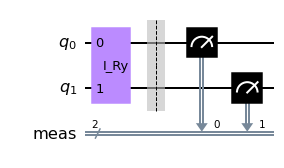

In [538]:
p=0.99
m=9
theta=pi/3
Ng=2*m+1
A=Operator([[1,0],[0,1]])
B=Operator(RYGate(2*Ng*theta))
C=A.tensor(B)
circ=QuantumCircuit(2)
circ.unitary(C,[0,1],label='I_Ry')
circ.measure_all()
circ.draw('mpl')

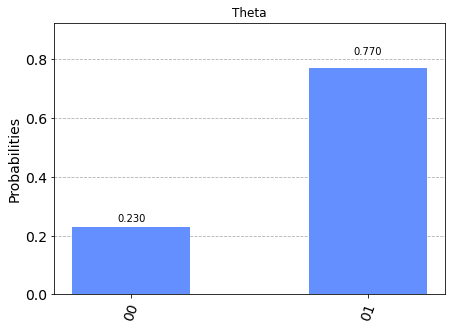

In [539]:
simulator=Aer.get_backend('aer_simulator')
circ=transpile(circ,simulator)
result=simulator.run(circ).result()
counts=result.get_counts(circ)
plot_histogram(counts,title='Theta')

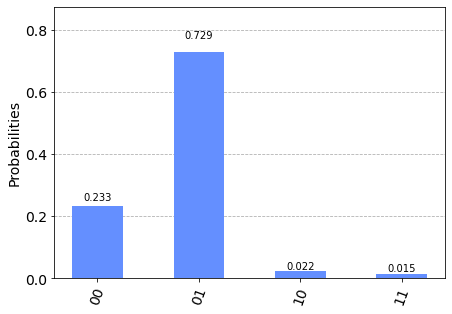

In [540]:
# Create an empty noise model
noise_depolarizing = NoiseModel()
noise_depolarizing.add_basis_gates(['unitary'])
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(1-p**(m+1), 2)
noise_depolarizing.add_all_qubit_quantum_error(error, 'I_Ry')
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_depolarizing)
# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)
# Run and get counts
result_noise = sim_noise.run(circ_tnoise).result()
counts_noise = result_noise.get_counts(0)
# Plot noisy output
plot_histogram(counts_noise)

In [542]:
print(counts_noise)

{'00': 239, '01': 747, '11': 15, '10': 23}


In [547]:
theta=np.arcsin(np.sqrt(a))
print(theta)

0.4636476090008061


計算の軽量化を試みる

In [553]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
n2=[]
theta_0=[pi/100]
Ng=[]
m=[]
it=100
N=1000
n=2
d=2**n
ans=0
for k in range(5):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    n2.append([])
    for i in range(it):
        theta_m=2*Ng[k]*theta_0[i+k*it]+pi/2
        I=Operator([[1,0],[0,1]])
        Ry=Operator(RYGate(2*Ng[k]*theta))
        Ry_e=Operator(RYGate(-theta_m))
        Ry_2=I.tensor(Ry)
        Ry_2_e=I.tensor(Ry_e)
        circ_e2=QuantumCircuit(2)
        circ_e2.unitary(Ry_2,[0,1],label='Ry_2')
        circ_e2.unitary(Ry_2_e,[0,1],label='Ry_2_e')
        circ_e2.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        noise_depolarizing.add_basis_gates(['unitary'])
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), 2)
        noise_depolarizing.add_all_qubit_quantum_error(error, 'Ry_2')
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_e2_tnoise = transpile(circ_e2, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e2_tnoise,shots=N).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['00'])
        n1[k].append(counts_noise['01'])
        n2[k].append(N-n0[k][i]-n1[k][i])
        def func(x):
            angle=x[0]-theta_0[j+k*it]
            ans+=np.log((p**m[k])*(1+np.sin(2*Ng[k]*angle))+(2*(1-p**m[k]))/d)*n0[k][i]
            ans+=np.log((p**m[k])*(1-np.sin(2*Ng[k]*angle))+(2*(1-p**m[k]))/d)*n1[k][i]
            ans+=np.log((d-2)*(1-p**m[k])/d)*n2[k][i]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)

[0.847113594550087, 0.19678206562138778, 0.1978616673122125, 0.20298103297373532, 0.20430755858591554, 0.2015799895182288, 0.2011137808983795, 0.20469832442434432, 0.2016577301867913, 0.2018910193888307, 0.2028251827402891, 0.202903102279722, 0.2018910193888307, 0.20266937713686609, 0.20126913891573062, 0.20064797626187938, 0.19979505241853693, 0.19964012176916615, 0.19956267335866143, 0.19960139615409578, 0.20103611872088717, 0.2011137808983795, 0.2011137808983795, 0.2015799895182288, 0.2018910193888307, 0.20181324512501164, 0.20126913891573062, 0.20243575246420858, 0.2020466014912862, 0.20142454179679328, 0.20161885845216032, 0.20196880484522906, 0.20161885845216032, 0.20196880484522906, 0.20228005853819972, 0.20228005853819972, 0.20228005853819972, 0.2025914910787257, 0.20251361618686528, 0.20266937713686609, 0.20255255223682778, 0.20247468292920373, 0.20243575246420858, 0.20216331743459273, 0.20216331743459273, 0.2018910193888307, 0.20192991071813995, 0.2022022283406931, 0.20228005

In [666]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
n2=[]
theta_0=[pi/100]
Ng=[]
m=[]
it=100
N=1000
n=2
d=2**n
ans=0
for k in range(5):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    n2.append([])
    for i in range(it):
        theta_m=2*Ng[k]*theta_0[i+k*it]+pi/2
        I=Operator([[1,0],[0,1]])
        Ry=Operator(RYGate(2*Ng[k]*theta))
        Ry_e=Operator(RYGate(-theta_m))
        Ry_2=I.tensor(Ry)
        Ry_2_e=I.tensor(Ry_e)
        circ_e2=QuantumCircuit(2)
        circ_e2.unitary(Ry_2,[0,1],label='Ry_2')
        circ_e2.unitary(Ry_2_e,[0,1],label='Ry_2_e')
        circ_e2.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        noise_depolarizing.add_basis_gates(['unitary'])
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), 2)
        noise_depolarizing.add_all_qubit_quantum_error(error, 'Ry_2')
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_e2_tnoise = transpile(circ_e2, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e2_tnoise,shots=N).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['00'])
        n1[k].append(counts_noise['01'])
        n2[k].append(N-n0[k][i]-n1[k][i])
        def func(x):
            angle=x[0]-theta_0[i+k*it]
            ans+=np.log((p**m[k])*(1+np.sin(2*Ng[k]*angle))+(2*(1-p**m[k]))/d)*n0[k][i]
            ans+=np.log((p**m[k])*(1-np.sin(2*Ng[k]*angle))+(2*(1-p**m[k]))/d)*n1[k][i]
            ans+=np.log((d-2)*(1-p**m[k])/d)*n2[k][i]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)

[0.0469887571819563, 0.0, 0.09397833892979547, 0.0, 0.0, 0.9578866575228229, 0.8791339057480536, 0.7845993075593468, 0.04357822287819232, 0.0, 0.04549673247541807, 0.0, 0.9509956150664783, 0.00345041091327126, 0.08426519384872384, 0.0, 0.043789650389884485, 0.0, 0.04549673247542307, 0.0, 0.09340429727617229, 0.0, 0.04549673247542307, 0.0, 0.11779088363721603, 0.0, 0.04679759158837879, 0.0, 0.5659460230379959, 0.0, 0.8897624992405847, 0.7661878953699446, 0.02511449060815622, 0.9295269771849426, 0.49379964710716506, 0.0, 0.022953913554590238, 0.0, 0.9750053041028058, 0.0014637126958943912, 0.024631667705665154, 0.0, 0.8995939968018406, 0.7901177622913363, 0.04128701197104671, 0.0, 0.9421726156286481, 0.012933666803753338, 0.3822745419623663, 0.0, 0.9657896741588147, 0.8788574348801673, 0.05125644893713284, 0.868638819917293, 0.025765353846996897, 0.13213804466343457, 0.0, 0.022953913554590238, 0.0, 0.9783199196031246, 0.8535533905932737, 0.7163431280862418, 0.16903410887021286, 0.6965803

In [661]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
n2=[]
theta_0=[pi/100]
Ng=[]
m=[]
it=100
N=1000
n=2
d=2**n
for k in range(5):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    n2.append([])
    for i in range(it):
        theta_m=2*Ng[k]*theta_0[i+k*it]+pi/2
        I=Operator([[1,0],[0,1]])
        Ry=Operator(RYGate(2*Ng[k]*theta))
        Ry_e=Operator(RYGate(-theta_m))
        Ry_2=I.tensor(Ry)
        Ry_2_e=I.tensor(Ry_e)
        circ_e2=QuantumCircuit(2)
        circ_e2.unitary(Ry_2,[0,1],label='Ry_2')
        circ_e2.unitary(Ry_2_e,[0,1],label='Ry_2_e')
        circ_e2.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        noise_depolarizing.add_basis_gates(['unitary'])
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), 2)
        noise_depolarizing.add_all_qubit_quantum_error(error, 'Ry_2')
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_e2_tnoise = transpile(circ_e2, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e2_tnoise,shots=N).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise['00'])
        n1[k].append(counts_noise['01'])
        n2[k].append(N-n0[k][i]-n1[k][i])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]-theta_0[j+l*it]
                    ans+=np.log((p**m[l])*(1+np.sin(2*Ng[l]*angle))+(2*(1-p**m[l]))/d)*n0[l][j]
                    ans+=np.log((p**m[l])*(1-np.sin(2*Ng[l]*angle))+(2*(1-p**m[l]))/d)*n1[l][j]
                    ans+=np.log((d-2)*(1-p**m[l])/d)*n2[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)

[0.8603708366688508, 0.18562014070338612, 0.19263886007157255, 0.19028820427047888, 0.18902217699819704, 0.19009809394054913, 0.19416948117679778, 0.19662801877354968, 0.19763013664817708, 0.19832503484628947, 0.20057038147617068, 0.199098219877328, 0.19995002815299898, 0.20041522563415515, 0.1991756005642443, 0.19952395338322643, 0.19913690880878826, 0.19763013664817708, 0.19871148596237287, 0.19716738191729208, 0.1978616673122125, 0.19766871799894856, 0.19824777859086276, 0.1973987081571365, 0.19728303225092855, 0.19736014668094015, 0.1972059291865043, 0.19701322126888493, 0.1973987081571365, 0.19693615800681066, 0.19759155813554447, 0.19709029590667662, 0.19778447907647437, 0.19801607781237732, 0.19782307177617947, 0.19817053366480175, 0.1985955209171567, 0.19801607781237732, 0.19801607781237732, 0.19793886689181295, 0.1977073021874967, 0.19763013664817708, 0.19778447907647437, 0.19759155813554447, 0.1980933000710067, 0.1988274764594893, 0.19855687155975577, 0.19847958133363722, 0.1

In [668]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
n2=[]
theta_0=[pi/100]
Ng=[]
m=[]
qlist=[]
it=10
N=1000
n=5
for q in range(n):
    qlist.append(q)
d=2**n
N0='0'*n
N1='0'*(n-1)+'1'
I_1=Operator([[1,0],[0,1]])
I_n=Operator([[1,0],[0,1]])
for o in range(n-2):
    I_n=I_1.tensor(I_n)
for k in range(10):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    n2.append([])
    for i in range(it):
        theta_e=2*Ng[k]*theta_0[i+k*it]+pi/2
        Ry=Operator(RYGate(2*Ng[k]*theta))
        Ry_e=Operator(RYGate(-theta_e))
        Ry_n=I_n.tensor(Ry)
        Ry_n_e=I_n.tensor(Ry_e)
        circ_e_n=QuantumCircuit(n)
        circ_e_n.unitary(Ry_n,qlist,label='Ry_n')
        circ_e_n.unitary(Ry_n_e,qlist,label='Ry_n_e')
        circ_e_n.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        noise_depolarizing.add_basis_gates(['unitary'])
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), n)
        noise_depolarizing.add_all_qubit_quantum_error(error, 'Ry_n')
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_e_n_tnoise = transpile(circ_e_n, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e_n_tnoise,shots=N).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise[N0])
        n1[k].append(counts_noise[N1])
        n2[k].append(N-n0[k][i]-n1[k][i])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]-theta_0[j+l*it]
                    ans+=np.log((p**m[l])*(1+np.sin(2*Ng[l]*angle))+(2*(1-p**m[l]))/d)*n0[l][j]
                    ans+=np.log((p**m[l])*(1-np.sin(2*Ng[l]*angle))+(2*(1-p**m[l]))/d)*n1[l][j]
                    ans+=np.log((d-2)*(1-p**m[l])/d)*n2[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)

[0.8418707836927831, 0.19933039581876233, 0.2022022283406931, 0.20041522563415515, 0.19693615800681066, 0.19956267335866143, 0.19956267335866143, 0.20228005853819972, 0.1994852362281543, 0.19971758145676072, 0.20399514573085545, 0.20080319954813214, 0.20337085366008562, 0.20161885845216032, 0.20142454179679328, 0.20126913891573062, 0.20181324512501164, 0.2015799895182288, 0.20132740973991628, 0.20121087440050447, 0.1980933000710067, 0.1974372724736439, 0.200492797932625, 0.20047340380366785, 0.20012442971606245, 0.19964012176916615, 0.19979505241853693, 0.19962075860919917, 0.1994852362281543, 0.19950459445312235, 0.19944652189380846, 0.19902085048784748, 0.20053158829894538, 0.20066737671455315, 0.20057038147617068, 0.20006628952693598, 0.20027950117905685, 0.20027950117905685, 0.20000815567217226, 0.2002988882773387, 0.199098219877328, 0.19938845568194638, 0.20053158829894538, 0.2003958343169221, 0.20026011478409267, 0.19979505241853693, 0.20009535882978058, 0.20026011478409267, 0.20

[0.21098802403559797, 0.2096456008945466, 0.20438568956163689, 0.2018910193888307, 0.20154112338536156, 0.19929169277095518, 0.20134683474975656, 0.199098219877328, 0.20235789991367906, 0.2006576764004125, 0.2009972918412126, 0.2002988882773387, 0.20045401037757354, 0.19998877912843271, 0.20026011478409267, 0.20000815567217226, 0.2002988882773387, 0.20001784420802782, 0.2004055298876609, 0.2001825762383237, 0.20034735909976, 0.20012442971606245, 0.20012442971606245, 0.20027950117905685, 0.19995002815299898, 0.20009535882978058, 0.19987253465158605, 0.1999984673123053, 0.19983379212633418, 0.19994034084918316, 0.19986284875615656, 0.1999209667696424, 0.1997466317463899, 0.19993065372139573, 0.20000815567217226, 0.2001292750177106, 0.19995002815299898, 0.20006628952693598, 0.19989190697064385, 0.20012442971606245, 0.19987253465158605, 0.20005660011122262, 0.19981442192023102, 0.19998877912843271, 0.19993065372139573, 0.2000759791186039, 0.19982410693523428, 0.2000541777847878, 0.19979989

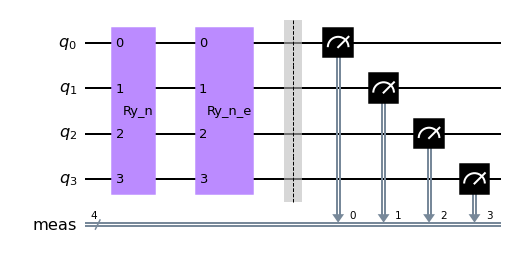

In [713]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results_e=[]
n0=[]
n1=[]
n2=[]
theta_0=[pi/4]
Ng=[]
m=[]
qlist=[]
it=2
N=1000
n=4
for q in range(n):
    qlist.append(q)
d=2**n
N0='0'*n
N1='0'*(n-1)+'1'
I_1=Operator([[1,0],[0,1]])
I_n=Operator([[1,0],[0,1]])
for o in range(n-2):
    I_n=I_1.tensor(I_n)
for k in range(100):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    n2.append([])
    for i in range(it):
        theta_e=2*Ng[k]*theta_0[i+k*it]+pi/2
        Ry=Operator(RYGate(2*Ng[k]*theta))
        Ry_e=Operator(RYGate(-theta_e))
        Ry_n=I_n.tensor(Ry)
        Ry_n_e=I_n.tensor(Ry_e)
        circ_e_n=QuantumCircuit(n)
        circ_e_n.unitary(Ry_n,qlist,label='Ry_n')
        circ_e_n.unitary(Ry_n_e,qlist,label='Ry_n_e')
        circ_e_n.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        noise_depolarizing.add_basis_gates(['unitary'])
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**m[k], n)
        noise_depolarizing.add_all_qubit_quantum_error(error, 'Ry_n')
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_e_n_tnoise = transpile(circ_e_n, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e_n_tnoise,shots=N).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise[N0])
        n1[k].append(counts_noise[N1])
        n2[k].append(N-n0[k][i]-n1[k][i])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]-theta_0[j+l*it]
                    ans+=np.log((p**m[l])*(1+np.sin(2*Ng[l]*angle))/2+(1-p**m[l])/d)*n0[l][j]
                    ans+=np.log((p**m[l])*(1-np.sin(2*Ng[l]*angle))/2+(1-p**m[l])/d)*n1[l][j]
                    ans+=np.log((d-2)*(1-p**m[l])/d)*n2[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results_e.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results_e)
print(statistics.mean(opt_results_e))
print(statistics.variance(opt_results_e))
circ_e_n.draw('mpl')

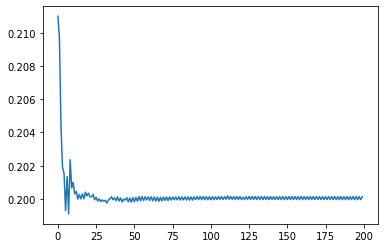

In [716]:
plt.plot(opt_results_e)
plt.show()

[0.21583066492195732, 0.20251361618686528, 0.20337085366008562, 0.1946295641889083, 0.20368291069305638, 0.20057038147617068, 0.20462014907056275, 0.20134683474975656, 0.2003376645836737, 0.19913690880878826, 0.19981442192023102, 0.19927234230548252, 0.19996940328869317, 0.19981442192023102, 0.2003764437027339, 0.2001535021856279, 0.20026011478409267, 0.20017288471153122, 0.20077409175857358, 0.200492797932625, 0.2007837941795614, 0.20055098453621764, 0.20090023692140793, 0.20080319954813214, 0.20053158829894538, 0.20066737671455315, 0.20052189044382873, 0.20066737671455315, 0.20084201239149463, 0.20066737671455315, 0.20084201239149463, 0.20069647871056373, 0.20066737671455315, 0.20062372668386722, 0.20082260561879173, 0.20061887689998253, 0.20070617972707783, 0.20055098453621764, 0.20077409175857358, 0.20051219276439933, 0.20079349677608282, 0.20053158829894538, 0.20060917746393672, 0.20044431392811415, 0.20068677786963446, 0.20047340380366785, 0.20073528383007225, 0.20047340380366785

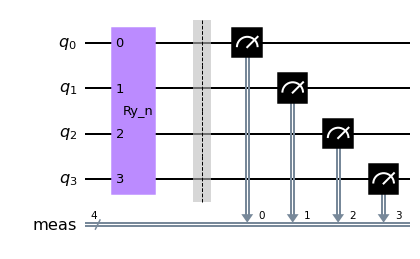

In [714]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results_c=[]
n0=[]
n1=[]
n2=[]
Ng=[]
m=[]
qlist=[]
it=2
N=1000
n=4
for q in range(n):
    qlist.append(q)
d=2**n
N0='0'*n
I_1=Operator([[1,0],[0,1]])
I_n=Operator([[1,0],[0,1]])
for o in range(n-2):
    I_n=I_1.tensor(I_n)
for k in range(100):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    n2.append([])
    for i in range(it):
        Ry=Operator(RYGate(2*Ng[k]*theta))
        Ry_n=I_n.tensor(Ry)
        circ_c_n=QuantumCircuit(n)
        circ_c_n.unitary(Ry_n,qlist,label='Ry_n')
        circ_c_n.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        noise_depolarizing.add_basis_gates(['unitary'])
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**m[k], n)
        noise_depolarizing.add_all_qubit_quantum_error(error, 'Ry_n')
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_c_n_tnoise = transpile(circ_c_n, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_c_n_tnoise,shots=N).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise[N0])
        n1[k].append(N-n0[k][i])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]
                    ans+=np.log((p**m[l])*(np.cos(Ng[l]*angle)**2)+(1-p**m[l])/d)*n0[l][j]
                    ans+=np.log((p**m[l])*(np.sin(Ng[l]*angle)**2)+((d-1)*(1-p**m[l]))/d)*n1[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results_c.append(np.sin(x[0])**2)
print(opt_results_c)
print(statistics.mean(opt_results_c))
print(statistics.variance(opt_results_c))
circ_c_n.draw('mpl')

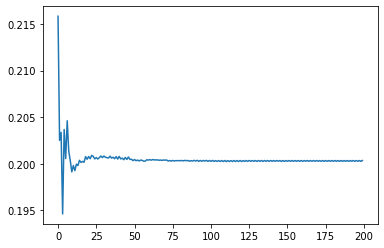

In [717]:
plt.plot(opt_results_c)
plt.show()

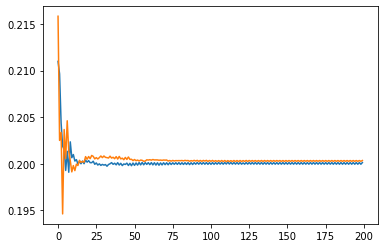

In [719]:
plt.plot(opt_results_e)
plt.plot(opt_results_c)
plt.show()

In [678]:
print(opt_results_c)

[0.22433977914764788, 0.21122524818316393, 0.2101979826440035, 0.20877865206342, 0.20587228354781145, 0.19979505241853693, 0.19755298246141276, 0.19987253465158605, 0.20212440932408132, 0.200492797932625, 0.2106718771004414, 0.2089361808331536, 0.20469832442434432, 0.20173548205669195, 0.20266937713686609, 0.20080319954813214, 0.20053158829894538, 0.20161885845216032, 0.20235789991367906, 0.2009584677680716, 0.20126913891573062, 0.2015799895182288, 0.19925299254569093, 0.19898217003055338, 0.19960139615409578, 0.19956267335866143, 0.1997563155285579, 0.2007255822868378, 0.20055098453621764, 0.19998877912843271, 0.20041522563415515, 0.20150226005392335, 0.1994078103805523, 0.19900150990604204, 0.1994852362281543, 0.19956267335866143, 0.19962075860919917, 0.20066737671455315, 0.20045401037757354, 0.19995002815299898, 0.19971758145676072, 0.19981442192023102, 0.19898217003055338, 0.1989628308614267, 0.19967885020350895, 0.2002988882773387, 0.2002988882773387, 0.20097787945380263, 0.200948

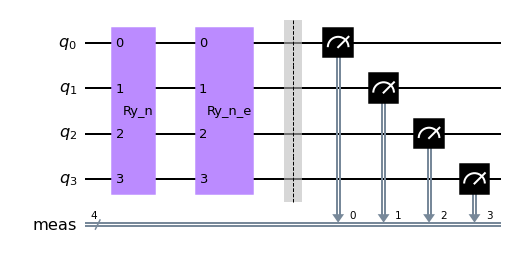

In [663]:
circ_e_n.draw('mpl')

In [646]:
a='0'*2+'1'*3
print(a)

00111


In [588]:
n=20
Ng=3
theta=pi/3
I=Operator([[1,0],[0,1]])
Ry=Operator(RYGate(2*Ng*theta))
for o in range(n-1):
    I_n=I.tensor(I)
Ry_n=I_n.tensor(Ry)
circ_e_n=QuantumCircuit(n)
circ_e_n.unitary(Ry_n,[0,n-1],label='Ry_n')
circ_e_n.measure_all()
circ_e_n.draw('mpl')

CircuitError: 'The amount of qubit(2)/clbit(0) arguments does not match the gate expectation (3).'

Operator([[ 0.8660254+0.j, -0.5      +0.j,  0.       +0.j, -0.       +0.j,
            0.       +0.j, -0.       +0.j,  0.       +0.j, -0.       +0.j,
            0.       +0.j, -0.       +0.j,  0.       +0.j, -0.       +0.j,
            0.       +0.j, -0.       +0.j,  0.       +0.j, -0.       +0.j],
          [ 0.5      +0.j,  0.8660254+0.j,  0.       +0.j,  0.       +0.j,
            0.       +0.j,  0.       +0.j,  0.       +0.j,  0.       +0.j,
            0.       +0.j,  0.       +0.j,  0.       +0.j,  0.       +0.j,
            0.       +0.j,  0.       +0.j,  0.       +0.j,  0.       +0.j],
          [ 0.       +0.j, -0.       +0.j,  0.8660254+0.j, -0.5      +0.j,
            0.       +0.j, -0.       +0.j,  0.       +0.j, -0.       +0.j,
            0.       +0.j, -0.       +0.j,  0.       +0.j, -0.       +0.j,
            0.       +0.j, -0.       +0.j,  0.       +0.j, -0.       +0.j],
          [ 0.       +0.j,  0.       +0.j,  0.5      +0.j,  0.8660254+0.j,
            0.       +

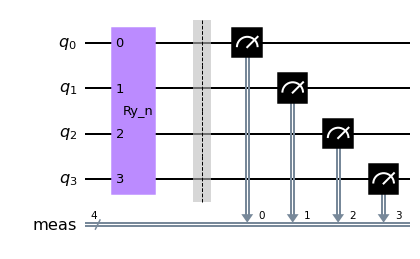

In [639]:
n=4
I_1=Operator([[1,0],[0,1]])
I=Operator([[1,0],[0,1]])
theta=pi/3
Ry=Operator(RYGate(theta))
for o in range(n-2):
    I=I_1.tensor(I)
Ry_n=I.tensor(Ry)
print(Ry_n)
circ_e_n=QuantumCircuit(4)
circ_e_n.unitary(Ry_n,[0,1,2,3],label='Ry_n')
circ_e_n.measure_all()
circ_e_n.draw('mpl')

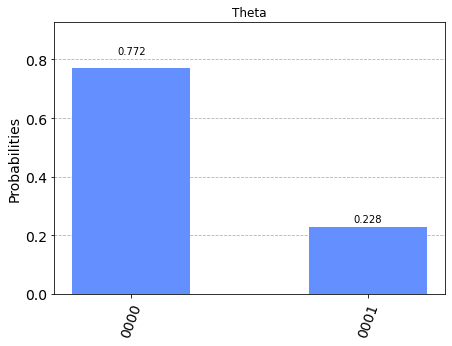

In [637]:
simulator=Aer.get_backend('aer_simulator')
circ_e_n=transpile(circ_e_n,simulator)
result_e_n=simulator.run(circ_e_n).result()
counts_e_n=result_e_n.get_counts(circ_e_n)
plot_histogram(counts_e_n,title='Theta')

In [582]:
a='0'*2
print(counts_noise[a])

384


In [ ]:
a=0.2
p=0.9
pi=np.pi
theta=np.arcsin(np.sqrt(a))
opt_results=[]
n0=[]
n1=[]
n2=[]
theta_0=[pi/100]
Ng=[]
m=[]
qlist=[]
it=10
N=1000
n=5
for q in range(n):
    qlist.append(q)
d=2**n
N0='0'*n
N1='0'*(n-1)+'1'
I_1=Operator([[1,0],[0,1]])
I_n=Operator([[1,0],[0,1]])
for o in range(n-2):
    I_n=I_1.tensor(I_n)
for k in range(10):
    Ng.append(2*k+1)
    m.append(k+1)
    n0.append([])
    n1.append([])
    n2.append([])
    for i in range(it):
        theta_e=2*Ng[k]*theta_0[i+k*it]+pi/2
        Ry=Operator(RYGate(2*Ng[k]*theta))
        Ry_e=Operator(RYGate(-theta_e))
        Ry_n=I_n.tensor(Ry)
        Ry_n_e=I_n.tensor(Ry_e)
        circ_e_n=QuantumCircuit(n)
        circ_e_n.unitary(Ry_n,qlist,label='Ry_n')
        circ_e_n.unitary(Ry_n_e,qlist,label='Ry_n_e')
        circ_e_n.measure_all()
        # Create an empty noise model
        noise_depolarizing = NoiseModel()
        noise_depolarizing.add_basis_gates(['unitary'])
        # Add depolarizing error to all single qubit u1, u2, u3 gates
        error = depolarizing_error(1-p**(k+1), n)
        noise_depolarizing.add_all_qubit_quantum_error(error, 'Ry_n')
        # Create noisy simulator backend
        sim_noise = AerSimulator(noise_model=noise_depolarizing)
        # Transpile circuit for noisy basis gates
        circ_e_n_tnoise = transpile(circ_e_n, sim_noise)
        # Run and get counts
        result_noise = sim_noise.run(circ_e_n_tnoise,shots=N).result()
        counts_noise = result_noise.get_counts(0)
        n0[k].append(counts_noise[N0])
        n1[k].append(counts_noise[N1])
        n2[k].append(N-n0[k][i]-n1[k][i])
        def func(x):
            ans=0
            for l in range(k+1):
                for j in range(i+1):
                    angle=x[0]-theta_0[j+l*it]
                    ans+=np.log((p**m[l])*(1+np.sin(2*Ng[l]*angle))+(2*(1-p**m[l]))/d)*n0[l][j]
                    ans+=np.log((p**m[l])*(1-np.sin(2*Ng[l]*angle))+(2*(1-p**m[l]))/d)*n1[l][j]
                    ans+=np.log((d-2)*(1-p**m[l])/d)*n2[l][j]
            return -ans
        x=opt.brute(func,[(0,pi/2)])
        opt_results.append(np.sin(x[0])**2)
        theta_0.append(x[0])
print(opt_results)